## Vehicle Detection

### Imports

In [1]:
import cv2
import glob
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time

from random import shuffle

from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

### Loading data

In [2]:
car_images = glob.glob("data/vehicles/*/*.*")
noncar_images = glob.glob("data/non-vehicles/*/*.*")
shuffle(car_images)
shuffle(noncar_images)
print(len(car_images), '         images of vehicles')
print(len(noncar_images), '        images of non-vehicles')
example_img = mpimg.imread(car_images[0])
print(example_img.shape, '  image shape')
print(example_img.dtype, '      image data type')

8792          images of vehicles
8968         images of non-vehicles
(64, 64, 3)   image shape
float32       image data type


### Visualizing the data

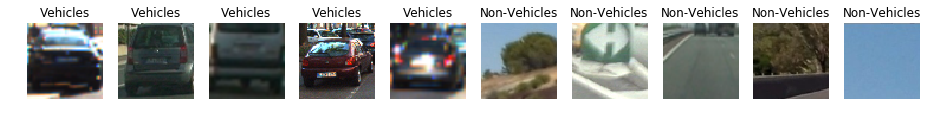

In [7]:
fig, axs = plt.subplots(1,10, figsize=(16, 2))

for i in np.arange(5):
    img = mpimg.imread(car_images[np.random.randint(0,len(car_images))])
    axs[i].axis('off')
    axs[i].set_title('Vehicles', fontsize=12)
    axs[i].imshow(img)
for i in np.arange(5,10):
    img = mpimg.imread(noncar_images[np.random.randint(0,len(noncar_images))])
    axs[i].axis('off')
    axs[i].set_title('Non-Vehicles', fontsize=12)
    axs[i].imshow(img)
    plt.savefig('output_images/data_visualization.png', 
            bbox_inches="tight")

## Histogram of Oriented Gradients (HOG)
-  Define HOG feature
-  Define color histogram features
-  Define Spatial Binning color histogram features

In [3]:
# Defining a function to return HOG features
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features
    
# Define a function to compute color histogram features
def color_hist(img, nbins=32, bins_range=(0, 256), vis=False):
    
    bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    # Generating bin centers
    bin_edges = channel1_hist[1] #all three bins are the same size
    bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges) - 1])/2
    
    hist_features = np.concatenate((channel1_hist[0],
                                    channel2_hist[0],
                                    channel3_hist[0]))
    if vis == True:
        return channel1_hist, channel2_hist, channel3_hist, bin_centers
    else:
        return hist_features

# Define a function to compute color histogram features  
# Pass the color_space flag as 3-letter all caps string
# like 'HSV' or 'LUV' etc.
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

#### HOG features visualization 

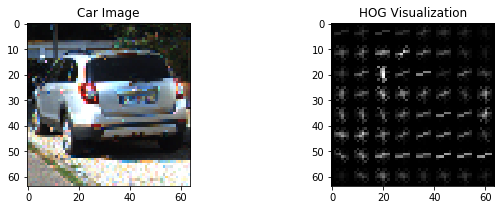

In [14]:
# Generate a random index to look at a car image
ind = np.random.randint(0, len(car_images))
# Read in the image
image = mpimg.imread(car_images[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure(figsize = (10,3))
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')
plt.savefig('output_images/hog_visualization.png', 
            bbox_inches="tight")

#### Color Histogram features visualization

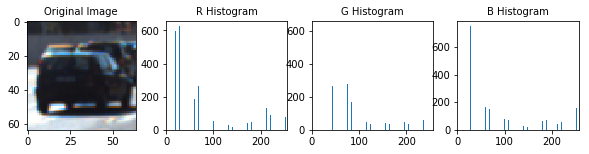

In [20]:
# Generate a random index to look at a car image
ind = np.random.randint(0, len(car_images))
# Read in the image
img = cv2.imread(car_images[ind])
image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Compute color histogram features of the test image
channel1_hist, channel2_hist, channel3_hist, bin_centers = color_hist(image, vis=True)
# Plot the examples
fig = plt.figure(figsize=(10,2));

plt.subplot(141)
plt.imshow(image)
plt.title('Original Image', fontsize=10)
plt.subplot(142)
plt.bar(bin_centers, channel1_hist[0])
plt.xlim(0, 256)
plt.title('R Histogram', fontsize=10);
plt.subplot(143)
plt.bar(bin_centers, channel2_hist[0])
plt.xlim(0, 256)
plt.title('G Histogram', fontsize=10);
plt.subplot(144)
plt.bar(bin_centers, channel3_hist[0])
plt.xlim(0, 256)
plt.title('B Histogram', fontsize=10);

plt.savefig('output_images/color_hist_vis.png', 
            bbox_inches="tight")

#### Spatial Binning of Color features visualization

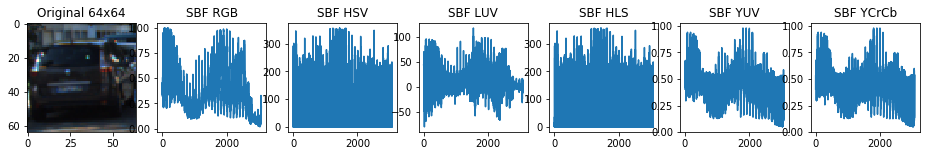

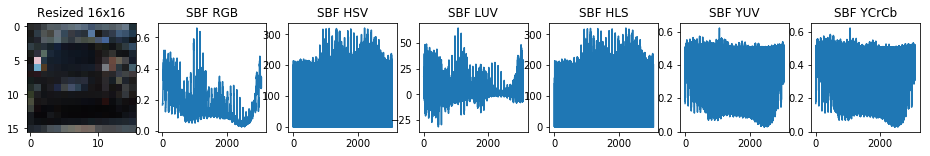

In [42]:
feature_vec1 = bin_spatial(image, color_space='RGB', size=(32, 32))
feature_vec2 = bin_spatial(image, color_space='HSV', size=(32, 32))
feature_vec3 = bin_spatial(image, color_space='LUV', size=(32, 32))
feature_vec4 = bin_spatial(image, color_space='HLS', size=(32, 32))
feature_vec5 = bin_spatial(image, color_space='YUV', size=(32, 32))
feature_vec6 = bin_spatial(image, color_space='YCrCb', size=(32, 32))

# Read in an image
# You can also read cutout2, 3, 4 etc. to see other examples
ind = np.random.randint(0, len(car_images))
# Read in the image
image = mpimg.imread(car_images[ind])
small_image = cv2.resize(image, (16, 16))

# Plot features
fig = plt.figure(figsize=(16,2))
plt.subplot(171)
plt.imshow(image)
plt.title('Original 64x64')
plt.savefig('output_images/bin_spatial1.png', bbox_inches="tight")

plt.subplot(172)
plt.plot(feature_vec1)
plt.title('SBF RGB')
plt.subplot(173)
plt.plot(feature_vec2)
plt.title('SBF HSV')
plt.subplot(174)
plt.plot(feature_vec3)
plt.title('SBF LUV')
plt.savefig('output_images/bin_spatial2.png', bbox_inches="tight")

plt.subplot(175)
plt.plot(feature_vec4)
plt.title('SBF HLS')
plt.subplot(176)
plt.plot(feature_vec5)
plt.title('SBF YUV')
plt.subplot(177)
plt.plot(feature_vec6)
plt.title('SBF YCrCb')
plt.savefig('output_images/bin_spatial3.png', bbox_inches="tight")

feature_vec11 = bin_spatial(small_image, color_space='RGB', size=(32, 32))
feature_vec12 = bin_spatial(small_image, color_space='HSV', size=(32, 32))
feature_vec13 = bin_spatial(small_image, color_space='LUV', size=(32, 32))
feature_vec14 = bin_spatial(small_image, color_space='HLS', size=(32, 32))
feature_vec15 = bin_spatial(small_image, color_space='YUV', size=(32, 32))
feature_vec16 = bin_spatial(small_image, color_space='YCrCb', size=(32, 32))

# Plot features
fig = plt.figure(figsize=(16,2))
plt.subplot(171)
plt.imshow(small_image)
plt.title('Resized 16x16')
plt.savefig('output_images/bin_spatial11.png', bbox_inches="tight")

plt.subplot(172)
plt.plot(feature_vec11)
plt.title('SBF RGB')
plt.subplot(173)
plt.plot(feature_vec12)
plt.title('SBF HSV')
plt.subplot(174)
plt.plot(feature_vec13)
plt.title('SBF LUV')
plt.savefig('output_images/bin_spatial22.png', bbox_inches="tight")

plt.subplot(175)
plt.plot(feature_vec14)
plt.title('SBF HLS')
plt.subplot(176)
plt.plot(feature_vec15)
plt.title('SBF YUV')
plt.subplot(177)
plt.plot(feature_vec16)
plt.title('SBF YCrCb')
plt.savefig('output_images/bin_spatial33.png', bbox_inches="tight")

#### Extract HOG Features from an Array of Car and Non-Car Images

In [4]:
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(images, color_space='RGB', spatial_size=(32, 32), 
                     hist_bins=32, orient=9, pix_per_cell=8,
                     cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in tqdm(images):
        file_features = []
        img = mpimg.imread(file) # idea for the progress came from "nhiddink"
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(img)
            
        if spatial_feat == True:
            # Apply bin_spatial() to get spatial color features
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist() also with a color space option now
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                                pix_per_cell, cell_per_block, vis=False,
                                                feature_vec=True)
            file_features.append(hog_features)
        # Append the new feature vector to the features list
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [56]:
def test_hog_parameters(color_space,orient,pix_per_cell,cell_per_block,hog_channel):
    t = time.time()
    # ################## Extract features ################################################
    car_features = extract_features(car_images, color_space=colorspace, orient=orient, 
                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                hog_channel=hog_channel)

    notcar_features = extract_features(noncar_images, color_space=colorspace, orient=orient, 
                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                hog_channel=hog_channel)
            
    # ################## Create Vector ################################################
    X = np.vstack((car_features, notcar_features)).astype(np.float64)
    X_scaler = StandardScaler().fit(X)
    scaled_X = X_scaler.transform(X)
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y,
                                            test_size=0.2,
                                            random_state=rand_state)
    # ################## Train Classifier ################################################
    svc = LinearSVC()
    svc.fit(X_train, y_train)

    print('Using:',orient,'orientations',pix_per_cell,'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    print('Test Accuracy of SVC: {0:.2f}%'.format(round(svc.score(X_test, y_test)*100, 4)))
    print('  Predictions:', svc.predict(X_test[0:10]))
    print('       Labels:', y_test[0:10])
    t2 = time.time()
    print()
    print(round(t2-t, 5), 'seconds to Extract, Create, Train, Predect 10 labels with SVC.')

In [57]:
for colorspace in ('YUV','RGB'):
    for orient in (11,9):
        for pix_per_cell in (16,8):
            cell_per_block = 2
            hog_channel = 'ALL'
            test_hog_parameters(colorspace,orient,pix_per_cell,cell_per_block,hog_channel)


100%|██████████████████████████████████████████████████████████| 8968/8968 [02:53<00:00, 51.62it/s]


Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 4356
Test Accuracy of SVC: 98.59%
  Predictions: [ 0.  1.  0.  1.  1.  0.  1.  0.  0.  0.]
       Labels: [ 0.  1.  0.  1.  1.  0.  1.  0.  0.  0.]

237.15927 seconds to Extract, Create, Train, Predect 10 labels with SVC.


100%|█████████████████████████████████████████████████████████| 8968/8968 [00:51<00:00, 175.65it/s]


Using: 9 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 4140
Test Accuracy of SVC: 98.45%
  Predictions: [ 0.  0.  1.  1.  1.  1.  1.  1.  0.  0.]
       Labels: [ 0.  0.  1.  1.  1.  1.  1.  1.  0.  0.]

110.14701 seconds to Extract, Create, Train, Predect 10 labels with SVC.


100%|█████████████████████████████████████████████████████████| 8968/8968 [00:42<00:00, 211.19it/s]


Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 4356
Test Accuracy of SVC: 97.38%
  Predictions: [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  1.]
       Labels: [ 0.  0.  0.  0.  0.  0.  1.  0.  1.  1.]

104.32091 seconds to Extract, Create, Train, Predect 10 labels with SVC.


100%|█████████████████████████████████████████████████████████| 8968/8968 [00:48<00:00, 186.09it/s]


Using: 9 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 4140
Test Accuracy of SVC: 97.61%
  Predictions: [ 1.  1.  0.  1.  1.  1.  1.  0.  0.  0.]
       Labels: [ 1.  1.  0.  1.  1.  1.  1.  0.  0.  0.]

107.36664 seconds to Extract, Create, Train, Predect 10 labels with SVC.


In [7]:
colorspace = 'YCrCb' 
orient = 10
pix_per_cell = 8 
cell_per_block = 2 
hog_channel = 'ALL'
t = time.time()
# ################## Extract features ################################################
car_features = extract_features(car_images, color_space=colorspace, orient=orient, 
            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
            hog_channel=hog_channel)

notcar_features = extract_features(noncar_images, color_space=colorspace, orient=orient, 
            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
            hog_channel=hog_channel)
            
# ################## Create Vector ################################################
X = np.vstack((car_features, notcar_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y,
                                        test_size=0.2,
                                        random_state=rand_state)
print('Using:',orient,'orientations',pix_per_cell,'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
t2 = time.time()
print()
print(round(t2-t, 5), 'seconds to Extract, Create Features')    

100%|██████████████████████████████████████████████████████████| 8968/8968 [04:45<00:00, 31.39it/s]


Using: 10 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 9048

702.52146 seconds to Extract, Create Features


In [6]:
# ################## Train Classifier ################################################
# Use a linear SVC
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'seconds to train SVC.')

143.11 seconds to train SVC.


In [8]:
t=time.time()
print('Test Accuracy of SVC: {0:.2f}%'.format(round(svc.score(X_test, y_test)*100, 4)))
print('  Predictions:', svc.predict(X_test[0:10]))
print('       Labels:', y_test[0:10])
t2 = time.time()
print()
print(round(t2-t, 5), 'seconds to Predect 10 labels with SVC.')    

Test Accuracy of SVC: 99.66%
  Predictions: [ 0.  1.  1.  1.  1.  0.  1.  0.  1.  0.]
       Labels: [ 0.  1.  1.  1.  1.  0.  1.  0.  1.  0.]

11.42348 seconds to Predect 10 labels with SVC.


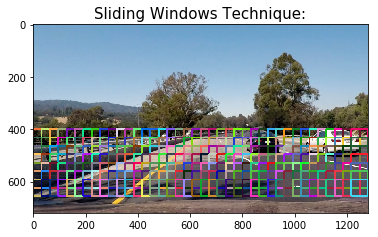

In [30]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                 xy_window=(128, 128), #(64, 64), (96, 96)
                 xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(255,0,0), thick=6, random_color=False):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Random color code copied from jeremy-shannon
        if random_color == True:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

test_img = mpimg.imread('test_images/test4.jpg')

windows =  slide_window(test_img,
                        x_start_stop=[None, None],
                        y_start_stop=[400, 656], #tune the parameters
                        xy_window=(64, 64),
                        xy_overlap=(0.5, 0.5))

window_img = draw_boxes(test_img, windows, random_color=True)
plt.imshow(window_img);
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)
plt.title('Sliding Windows Technique:', fontsize=15);
plt.savefig('output_images/sliding_windows.png', bbox_inches="tight")

In [31]:
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(image, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                            pix_per_cell, cell_per_block,
                                            vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)
    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [32]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                   spatial_size=(32, 32), hist_bins=32, orient=9, 
                   pix_per_cell=8, cell_per_block=2, hog_channel=0,
                   spatial_feat=True, hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [27]:
### Tweaked PARAMETERS
#color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
#orient = 10  # HOG orientations
#pix_per_cell = 8 # HOG pixels per cell
#cell_per_block = 2 # HOG cells per block
#hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

# Feature extraction parameters
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"


spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 64   # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

car_features = extract_features(car_images, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel,
                            spatial_feat=spatial_feat, hist_feat=hist_feat,
                            hog_feat=hog_feat)
notcar_features = extract_features(noncar_images, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel,
                            spatial_feat=spatial_feat, hist_feat=hist_feat,
                            hog_feat=hog_feat)


100%|██████████████████████████████████████████████████████████| 8968/8968 [01:40<00:00, 89.21it/s]


In [28]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
#rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2,
                                                    random_state=rand_state)

print('Using:',orient,'orientations,',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = {0:.2f}%'.format(round(svc.score(X_test, y_test)*100, 4)))
# Check the prediction time for a single sample
t=time.time()

Using: 11 orientations, 16 pixels per cell and 2 cells per block
Feature vector length: 4452
13.93 Seconds to train SVC...
Test Accuracy of SVC = 98.56%


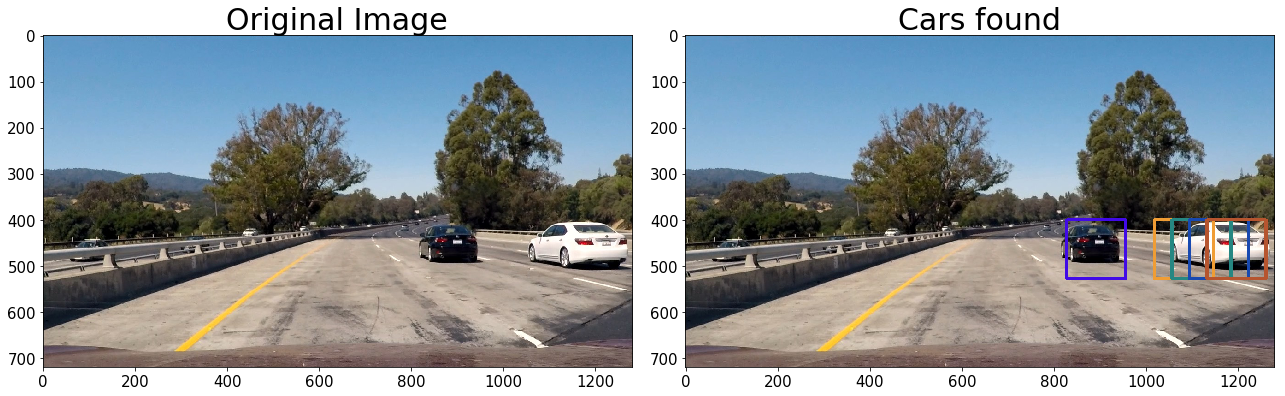

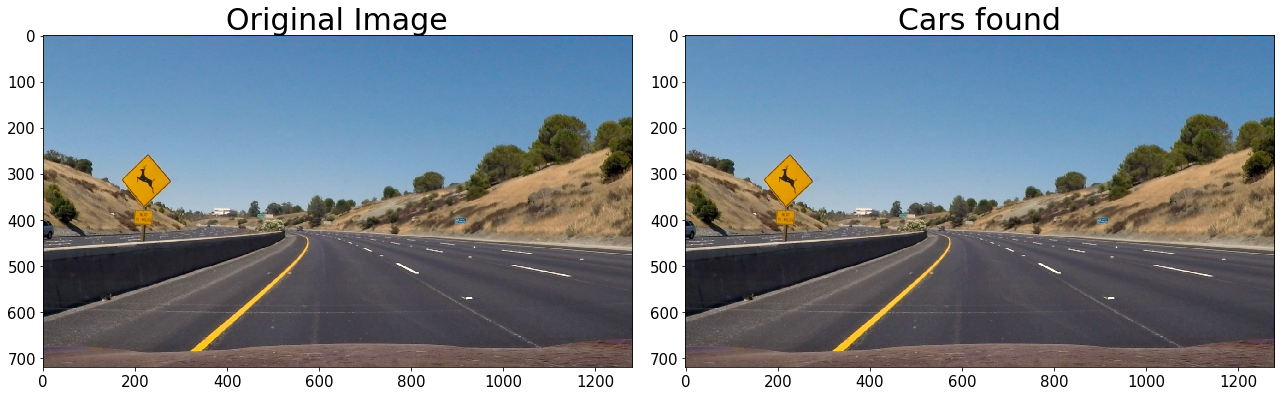

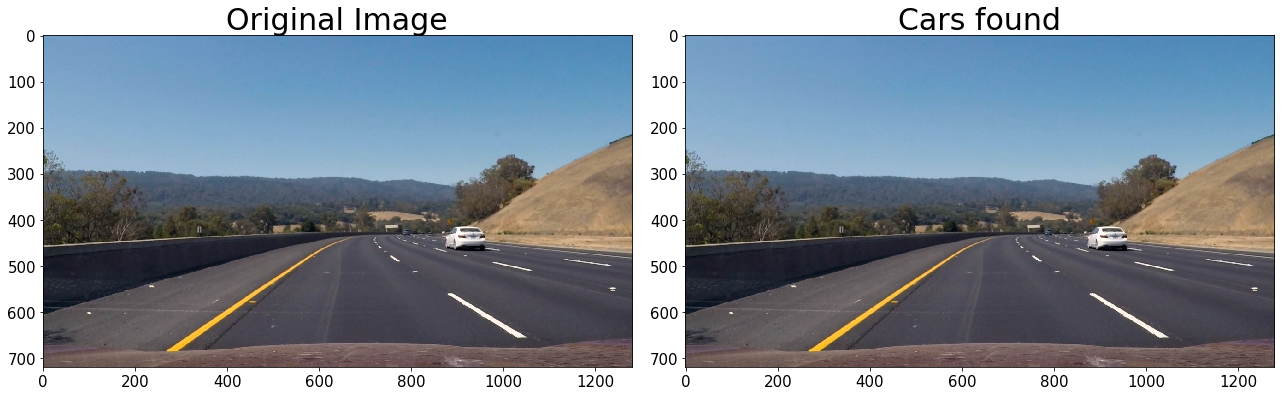

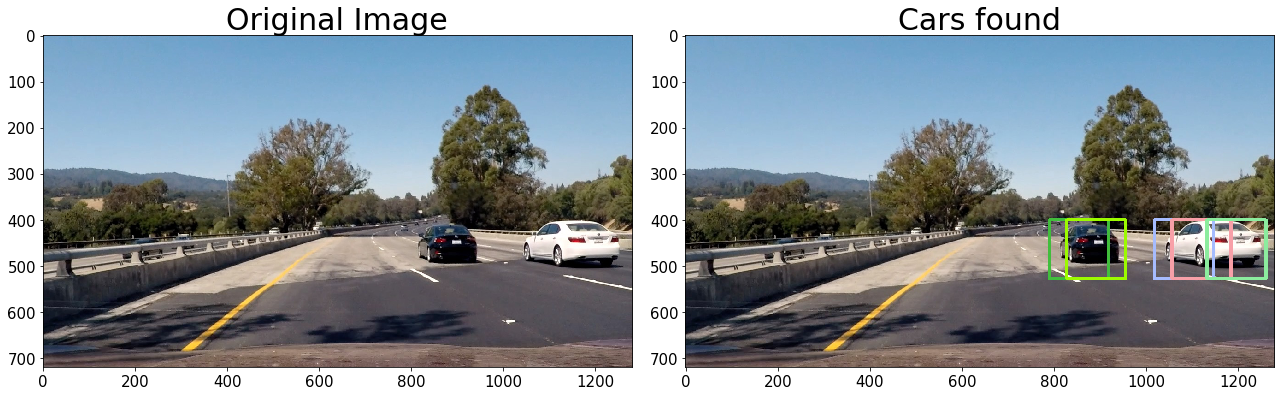

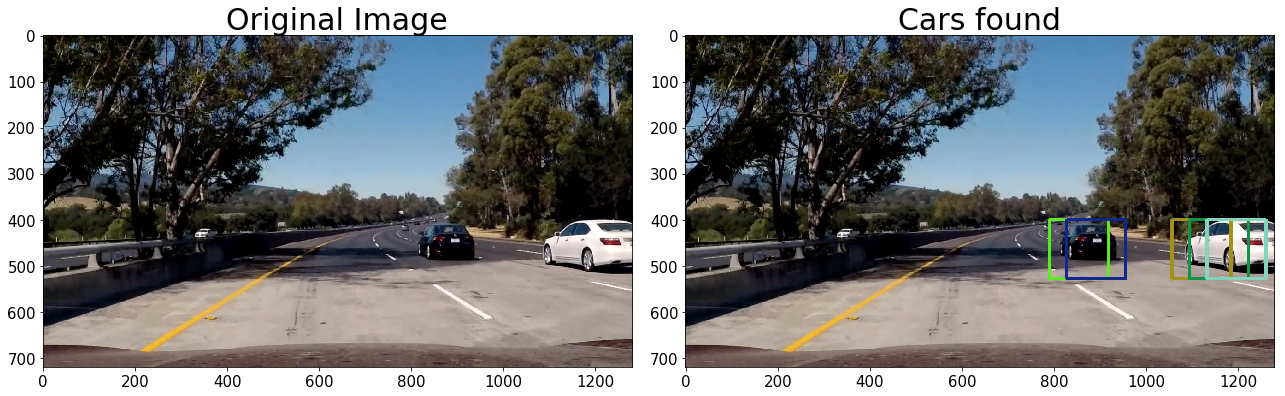

In [36]:
for i in range(1,6):
    
    fname = 'test_images/test{}.jpg'.format(i)
    image = mpimg.imread(fname)
    draw_image = np.copy(image)

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = image.astype(np.float32)/255

    windows =  slide_window(test_img,
                            x_start_stop=[600, None],
                            y_start_stop=[400, 656], #tune the parameters
                            xy_window=(128,128),
                            xy_overlap=(.7,.7))

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_image, hot_windows, random_color=True) 
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,9))
    plt.tight_layout()
    ax1.imshow(draw_image)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(window_img)
    ax2.set_title('Cars found', fontsize=30)
    plt.savefig('output_images/windows.png', bbox_inches="tight")

In [37]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (255,0,0), 8)
    # Return the image
    return img

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

In [38]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler,
              orient, pix_per_cell, cell_per_block,
              spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch,
                                     (np.int(imshape[1]/scale),
                                      np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bbox_list=[] #https://github.com/preritj/Vechicle-Detection-Tracking
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features,
                                                          hist_features,
                                                          hog_features)).reshape(1, -1))  
            
            # Scale features and make a prediction  
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),
                              (xbox_left+win_draw,ytop_draw+win_draw+ystart),
                              (255,0,0),8)
                bbox_list.append(((xbox_left, ytop_draw+ystart), #github.com/preritj
                                  (xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    
    return bbox_list

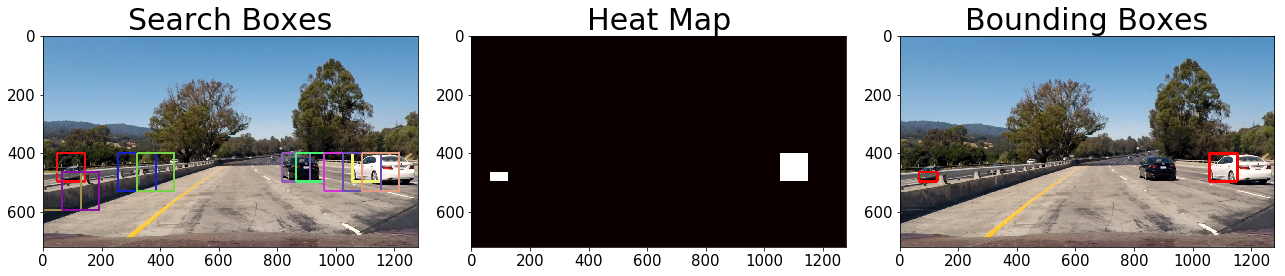

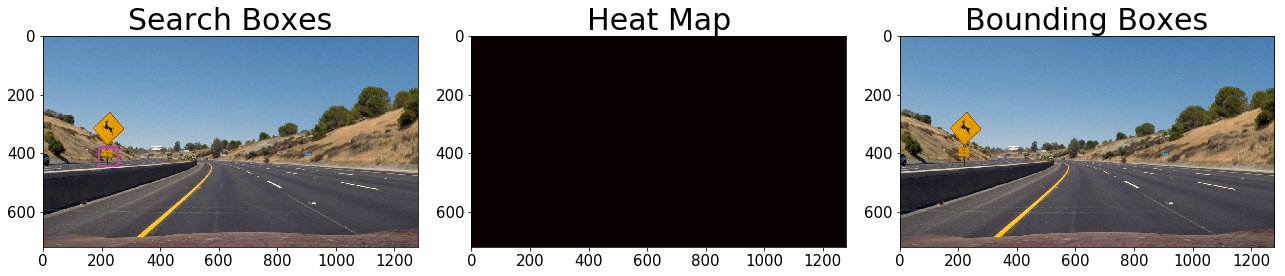

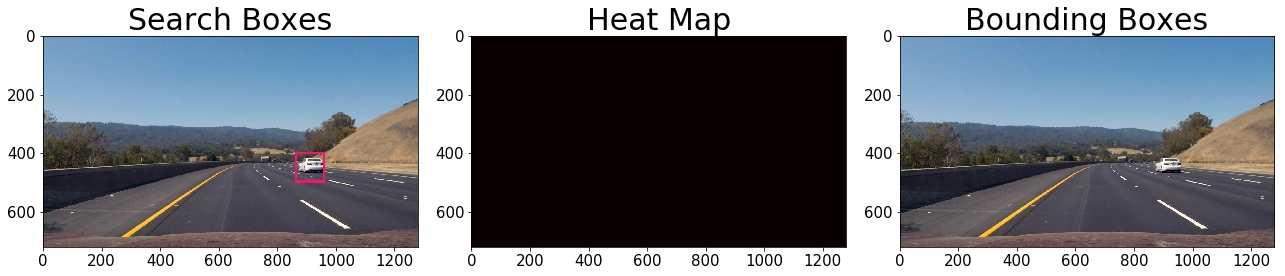

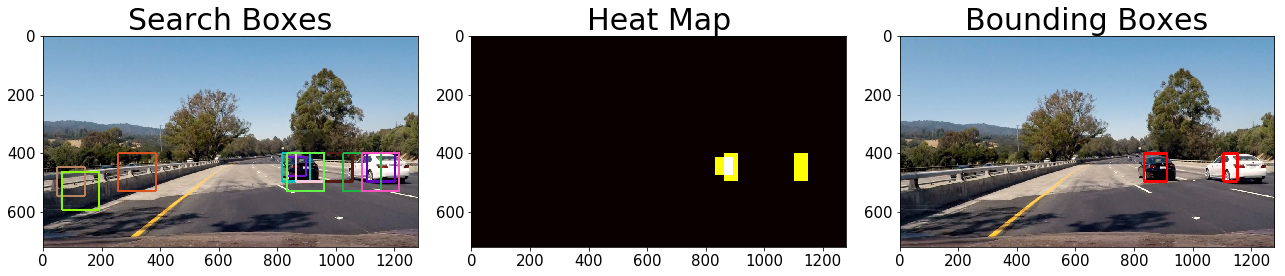

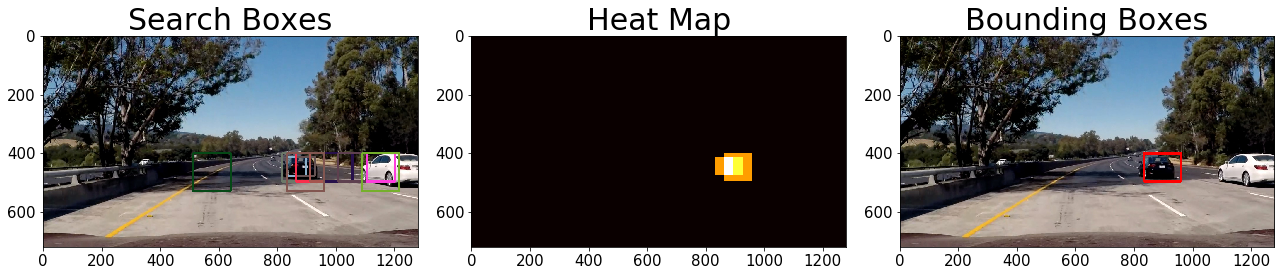

In [39]:
for i in range(1,6):
    
    fname = 'test_images/test{}.jpg'.format(i)
    img = mpimg.imread(fname)
    
    orient = 11
    pix_per_cell = 16
    #orient=10
    #pix_per_cell=8
    cell_per_block=2
    spatial_size=(32, 32)
    hist_bins=64
    
    bbox_list = []
    
    
    ystart = 380
    ystop = 550
    scale = 1.0
    bbox_list.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
    
    ystart = 400
    ystop = 600
    scale = 1.5
    bbox_list.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
    
    ystart = 400
    ystop = 656
    scale = 2.0
    bbox_list.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
   
    # Copied from 'jeremy-shannon'
    bbox_list = [item for sublist in bbox_list for item in sublist] 
    
    out_img = draw_boxes(img, bbox_list, random_color=True)
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat, bbox_list)
    heat = apply_threshold(heat, 2)  

    # Find final boxes from heatmap using label function
    labels = label(heat)
    new_img = draw_labeled_bboxes(np.copy(img), labels)

    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,9))
    plt.tight_layout()
    ax1.imshow(out_img)
    ax1.set_title('Search Boxes', fontsize=30)
    ax2.imshow(heat, cmap='hot')
    ax2.set_title('Heat Map', fontsize=30)
    ax3.imshow(new_img)
    ax3.set_title('Bounding Boxes', fontsize=30)
    #plt.savefig('output_images/heat_map1.png', bbox_inches="tight")

In [40]:
def process_image(img):
    
    orient = 11
    pix_per_cell = 16
    #orient=10
    #pix_per_cell=8
    cell_per_block=2
    spatial_size=(32, 32)
    hist_bins=64
    
    bbox_list = []
    
    ystart = 380
    ystop = 550
    scale = 1.0
    bbox_list.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
    
    ystart = 400
    ystop = 600
    scale = 1.5
    bbox_list.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
    
    ystart = 400
    ystop = 656
    scale = 2.0
    bbox_list.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
    bbox_list = [item for sublist in bbox_list for item in sublist] 
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat, bbox_list)
    heat = apply_threshold(heat, 2)  

    # Find final boxes from heatmap using label function
    labels = label(heat)
    new_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return new_img

In [41]:
test_output = "test_videos/test_output.mp4"
clip = VideoFileClip("test_video.mp4")
test_clip = clip.fl_image(process_image)
%time test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video test_videos/test_output.mp4
[MoviePy] Writing video test_videos/test_output.mp4


 97%|████████████████████████████████████████████████████████████▍ | 38/39 [00:51<00:01,  1.31s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos/test_output.mp4 

Wall time: 53.1 s


In [42]:
output = "test_videos/project_output.mp4"
clip = VideoFileClip("project_video.mp4")
clip = clip.fl_image(process_image)
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video test_videos/project_output.mp4
[MoviePy] Writing video test_videos/project_output.mp4


100%|█████████████████████████████████████████████████████████▉| 1260/1261 [27:48<00:01,  1.24s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos/project_output.mp4 

Wall time: 27min 49s
